In [42]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from warnings import filterwarnings
filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [43]:
data = pd.read_csv('house_prices_train.csv')

# Drop the 'Id' colum since it's unnecessary for  the prediction process.
data.drop("Id", axis = 1, inplace=True)

#check the numbers of samples and features
print("The data size is: {} ".format(data.shape))

The data size is: (1460, 80) 


In [44]:
data.select_dtypes('number').corrwith(data['SalePrice']).sort_values(ascending=False).head()

SalePrice     1.000
OverallQual   0.791
GrLivArea     0.709
GarageCars    0.640
GarageArea    0.623
dtype: float64

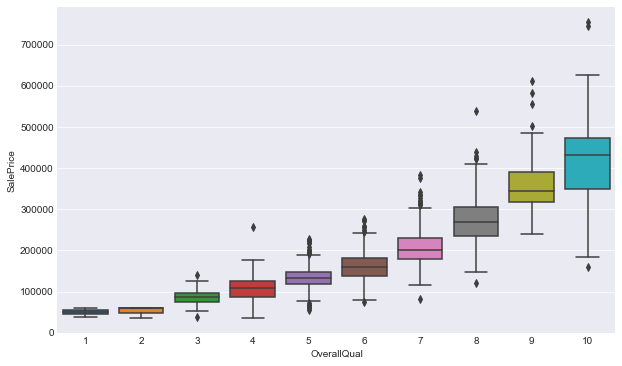

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(x='OverallQual', y='SalePrice', data=data)

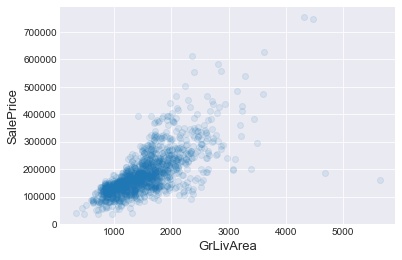

In [46]:
fig, ax = plt.subplots()
ax.scatter(x=data['GrLivArea'], y=data['SalePrice'], alpha=.1)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

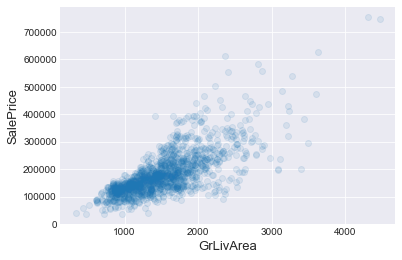

In [47]:
# Removing outliers
data = data.drop(data[(data['GrLivArea'] > 4000) & (data['SalePrice'] < 300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(data['GrLivArea'], data['SalePrice'], alpha=.1)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

mu = 180932.92 and sigma = 79467.79



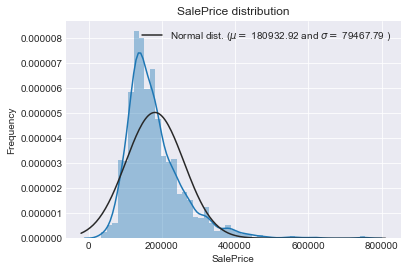

In [48]:
# from scipy.stats import norm, skew
sns.distplot(data['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
mu, sigma = norm.fit(data['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Labels and info
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

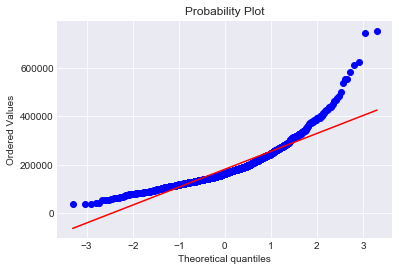

In [49]:
# QQ-plot
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show()

   mu = 12.02
sigma =  0.40


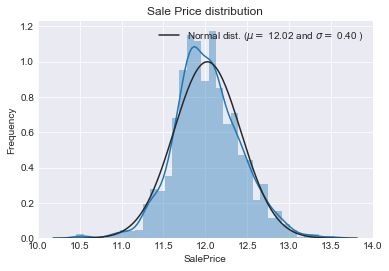

In [50]:
# Log transform the sale price
data["SalePrice"] = np.log1p(data["SalePrice"])

# Check the new distribution 
sns.distplot(data['SalePrice'] , fit=norm)

# Get mean and standard deviation
mu, sigma = norm.fit(data['SalePrice'])
print('   mu = {:.2f}'.format(mu))
print('sigma =  {:.2f}'.format(sigma))

# Labels and info
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

In [51]:
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Percentage': all_data_na})
missing_data.head(20)

,Missing Percentage
PoolQC,99.588
MiscFeature,96.296
Alley,93.759
Fence,80.727
FireplaceQu,47.325
LotFrontage,17.764
GarageYrBlt,5.556
GarageType,5.556
GarageFinish,5.556
GarageQual,5.556


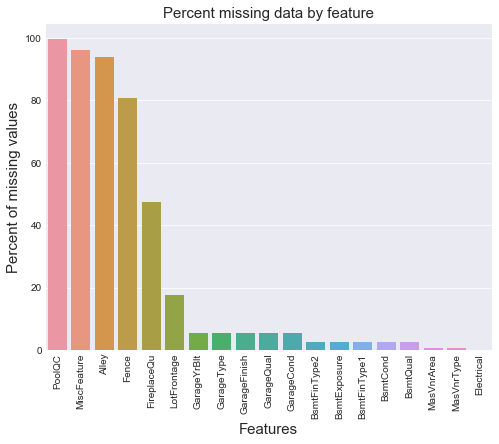

In [52]:
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [53]:
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

In [54]:
# Dummify
data = pd.get_dummies(data, prefix='dummy')

# Some Stackoverflow code to fix duplicate column names
cols = pd.Series(data.columns)

for dup in data.columns.get_duplicates():
    cols[data.columns.get_loc(dup)] =\
    [dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(data.columns.get_loc(dup).sum())]

data.columns = cols

data.shape

(1458, 293)

In [55]:
# Get null columns
null_cols = data.isnull().sum()
null_cols = list(null_cols[null_cols != 0].index)
null_cols

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [56]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Save for later
saleprice = data.pop('SalePrice')

# Regress null values. Use .values() because it'll complain about dupe columns otherwise
for i in null_cols:
    x = data.fillna(-100)
    y = x.pop(i)

    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)
    reg = XGBRegressor()
    reg.fit(xtrain.values, ytrain.values)      
    pred = reg.predict(xtest.values)
    r2 = r2_score(ytest, pred)

    # If we can reasonably predict these values, do so
    if r2 > .20:
        print('regressing', i, 'with an r2 of', round(r2, 3))
        data['predicted'] = reg.predict(data.fillna(data.median()).drop(i, axis=1).values)
        data[i] = np.where(data[i].isnull(), data['predicted'], data[i])
        del data['predicted']

    # Otherwise, just take the median
    else:
        print('averaging', i)
        data[i] = data[i].fillna(data[i].median())

regressing LotFrontage with an r2 of 0.3
regressing MasVnrArea with an r2 of 0.545
regressing GarageYrBlt with an r2 of 0.999


In [14]:
# Alternative way to do it
# #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
# data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
#     lambda x: x.fillna(x.median()))

# for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
#     data[col] = data[col].fillna('None')
    
# for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
#     data[col] = data[col].fillna(0)
    
# for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
#     data[col] = data[col].fillna(0)
    
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     data[col] = data[col].fillna('None')

# data["MasVnrType"] = data["MasVnrType"].fillna("None")
# data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

# #     MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
# data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])

# #     Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
# data = data.drop(['Utilities'], axis=1)

# #     Functional : data description says NA means typical
# data["Functional"] = data["Functional"].fillna("Typ")

# #     Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
# data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

# #     KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
# data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

# #     Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
# data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
# data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

# #     SaleType : Fill in again with most frequent which is "WD"
# data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])

# #     MSSubClass : Na most likely means No building class. We can replace missing values with None
# data['MSSubClass'] = data['MSSubClass'].fillna("None")

In [57]:
# Check remaining missing values if any 
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [58]:
# Add feature for total square footage 
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [62]:
numeric_feats = data.dtypes[data.dtypes != "object"].index
numeric_feats = [i for i in numeric_feats if 'dummy' not in i]

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features")
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)

Skew in numerical features


,Skew
MiscVal,24.435
PoolArea,15.933
LotArea,12.561
3SsnPorch,10.287
LowQualFinSF,8.996
KitchenAbvGr,4.480
BsmtFinSF2,4.248
ScreenPorch,4.115
BsmtHalfBath,4.096
EnclosedPorch,3.084


In [63]:
skewness = skewness[np.abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lambda_ = 0.15
for i in skewed_features:
    #print(data[i].head(1)) # useful to double-check what it's doing
    data[i] = boxcox1p(data[i], lambda_)
    #print(data[i].head(1))
    #print()

There are 37 skewed numerical features to Box Cox transform


In [64]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits=4, shuffle=True)

x = data.fillna(-100)#.drop('y', axis=1)
y = saleprice

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2)

In [65]:
from sklearn.linear_model import Lasso

lasso = Pipeline([
    ('scale', RobustScaler()),
    ('regress', Lasso())
])

params = {
    'scale__quantile_range': [(25,75), (20,80), (10,90), (5,95)],
    'regress__alpha': [.01, .001, .0001, .0005],
}

grid = GridSearchCV(lasso, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
lasso = grid.best_estimator_
print(lasso, '\n')

cv = cross_val_score(lasso, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(10, 90), with_centering=True,
       with_scaling=True)), ('regress', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]) 

Mean score: 0.9197662137641678
Std Dev:    0.018102392768791047


In [66]:
%timeit cross_val_score(lasso, xtrain, ytrain, cv=kf, scoring='r2')

1 loop, best of 3: 907 ms per loop


In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [68]:
# Linear regression: fast but not good (probably because of fillna(-100))

%timeit cross_val_score(LinearRegression(), xtrain, ytrain, cv=kf, scoring='r2')

c = cross_val_score(LinearRegression(), xtrain, ytrain, cv=kf, scoring='r2')
c.mean()

1 loop, best of 3: 365 ms per loop


0.3618070704394592

In [69]:
# Decision tree is blazing fast and pretty good. Might be useful in a production environment

%timeit c = cross_val_score(DecisionTreeRegressor(max_depth=3), xtrain, ytrain, cv=kf, scoring='r2')
c = cross_val_score(DecisionTreeRegressor(max_depth=3), xtrain, ytrain, cv=kf, scoring='r2')
c.mean()

10 loops, best of 3: 76.5 ms per loop


0.7459027759924091

In [31]:
%timeit c = cross_val_score(DecisionTreeRegressor(max_depth=6), xtrain, ytrain, cv=kf, scoring='r2')
c = cross_val_score(DecisionTreeRegressor(max_depth=6), xtrain, ytrain, cv=kf, scoring='r2')
c.mean()

10 loops, best of 3: 187 ms per loop


0.7536213952585767

In [35]:
# SVR - good but slooowwww

%timeit c = cross_val_score(SVR(kernel='rbf'), xtrain, ytrain, cv=kf, scoring='r2')
c = cross_val_score(SVR(kernel='rbf'), xtrain, ytrain, cv=kf, scoring='r2')
c.mean()

1 loop, best of 3: 1.18 s per loop


0.8234602180352047

In [34]:
# Poly kernel -- better but even slower

%timeit c = cross_val_score(SVR(kernel='poly'), xtrain, ytrain, cv=kf, scoring='r2')
c = cross_val_score(SVR(kernel='poly'), xtrain, ytrain, cv=kf, scoring='r2')
c.mean()

1 loop, best of 3: 1.98 s per loop


0.8511148445363835

In [36]:
# Linear kernel - even better, even slower

%timeit c = cross_val_score(SVR(kernel='linear'), xtrain, ytrain, cv=kf, scoring='r2')
c = cross_val_score(SVR(kernel='linear'), xtrain, ytrain, cv=kf, scoring='r2')
c.mean()

1 loop, best of 3: 1min 52s per loop


0.8893397953464085

In [37]:
%timeit cross_val_score(lasso, xtrain, ytrain, cv=kf, scoring='r2')

cv = cross_val_score(lasso, xtrain, ytrain, cv=kf, scoring='r2')
cv.mean()

1 loop, best of 3: 563 ms per loop


0.9229412842594303

In [21]:
from sklearn.linear_model import ElasticNet

enet = Pipeline([
    ('scale', RobustScaler()),
    ('regress', ElasticNet())
])

params = {'scale__quantile_range': [(25,75), (30,70), (20,80), (10,90), (5,95)],
          'regress__alpha': [1, .1, .01, .02, .03, .001],
          'regress__l1_ratio': [1, .4, .5, .6, .1, .01, .02, .03, .001],
          'regress__normalize': [True, False],
         }

grid = GridSearchCV(enet, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
enet = grid.best_estimator_
print(enet, '\n')

cv = cross_val_score(enet, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(10, 90), with_centering=True,
       with_scaling=True)), ('regress', ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]) 

Mean score: 0.914106638099
Std Dev:    0.0172150025549


In [22]:
from sklearn.kernel_ridge import KernelRidge

krr = Pipeline([
    ('scale', RobustScaler()),
    ('regress', KernelRidge())
])

params = {'scale__quantile_range': [(20,80), (10,90), (5,95), (1,99)],
          'regress__alpha': [.1, .01, .001],
          'regress__degree': [1,2,3],
          'regress__kernel': ['polynomial', 'linear', 'rbf']
         }

grid = GridSearchCV(krr, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
krr = grid.best_estimator_
print(krr, '\n')

cv = cross_val_score(krr, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(20, 80), with_centering=True,
       with_scaling=True)), ('regress', KernelRidge(alpha=0.1, coef0=1, degree=1, gamma=None, kernel='polynomial',
      kernel_params=None))]) 

Mean score: 0.915233892105
Std Dev:    0.00451324610158


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gboost = Pipeline([
    ('scale', RobustScaler()),
    ('regress', GradientBoostingRegressor(learning_rate=0.05))
])

params = {'scale__quantile_range': [(5,95), (1,99)],
    'regress__n_estimators': [500],
          'regress__max_depth': [2,3],
          'regress__max_features': ['sqrt'],
          'regress__min_samples_leaf': [1,2,3],
          'regress__min_samples_split': [2,5],
          'regress__loss': ['huber']
         }

grid = GridSearchCV(gboost, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
gboost = grid.best_estimator_

cv = cross_val_score(gboost, xtrain, ytrain, cv=kf, scoring='r2')

print(gboost, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(1, 99), with_centering=True,
       with_scaling=True)), ('regress', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_le...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))]) 

Mean score: 0.917307234352
Std Dev:    0.014885593399


In [24]:
xg = Pipeline([
    ('scale', RobustScaler()),
    ('regress', XGBRegressor())
])

params = {'scale__quantile_range': [(10,90), (5,95), (1,99)],
    'regress__n_estimators': [500],
    'regress__max_depth': [2,3],   
         }

grid = GridSearchCV(xg, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
xg = grid.best_estimator_
print(xg, '\n')

cv = cross_val_score(xg, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(10, 90), with_centering=True,
       with_scaling=True)), ('regress', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]) 

Mean score: 0.9059044032
Std Dev:    0.00850013899796


In [25]:
from sklearn.ensemble import AdaBoostRegressor

ada = Pipeline([
    ('scale', RobustScaler()),
    ('regress', AdaBoostRegressor())
])

params = {'scale__quantile_range': [(20,80), (10,90), (5,95)],
    'regress__n_estimators': [125,150,175],
    'regress__loss': ['linear'],
         }

grid = GridSearchCV(ada, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
ada = grid.best_estimator_
print(ada, '\n')

cv = cross_val_score(ada, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(10, 90), with_centering=True,
       with_scaling=True)), ('regress', AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=125, random_state=None))]) 

Mean score: 0.828165539782
Std Dev:    0.0119751065681


In [26]:
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ('scale', RobustScaler()),
    ('regress', KNeighborsRegressor(n_jobs=-1))
])

params = {'scale__quantile_range': [(40,60), (30,70), (20,80), (10,90)],
    'regress__n_neighbors': np.arange(7,11,2),
    'regress__p': [1],
    'regress__leaf_size': np.arange(1,3,1),
         }

grid = GridSearchCV(knn, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
knn = grid.best_estimator_
print(knn, '\n')

cv = cross_val_score(knn, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())
# Really poor performance -- we won't use it to ensemble

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(40, 60), with_centering=True,
       with_scaling=True)), ('regress', KNeighborsRegressor(algorithm='auto', leaf_size=1, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=1,
          weights='uniform'))]) 

Mean score: 0.812456440829
Std Dev:    0.0185290185417


In [27]:
from sklearn.linear_model import LinearRegression

lin = Pipeline([
    ('scale', RobustScaler()),
    ('regress', LinearRegression())
])

params = {'scale__quantile_range': [(40,60), (30,70), (20,80), (10,90), (5,95), (1,99)],
    'regress__normalize': [False, True],
         }

grid = GridSearchCV(lin, param_grid=params, cv=kf, scoring='r2').fit(xtrain, ytrain)
lin = grid.best_estimator_
print(lin, '\n')

cv = cross_val_score(lin, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())
# We'll also leave this out one of the ensemble

Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(40, 60), with_centering=True,
       with_scaling=True)), ('regress', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]) 

Mean score: 0.887380830418
Std Dev:    0.0195022609212


In [31]:
from sklearn.model_selection import GridSearchCV
from mlxtend.regressor import StackingRegressor
from itertools import combinations

regs = [lasso, krr, enet, gboost, xg, ada]
reg_combinations =\
[list(i) for i in combinations(regs, 3)]

reg = StackingRegressor(regressors=[LinearRegression()], meta_regressor=lasso)
params = {'regressors': reg_combinations,
          'meta_regressor': regs,
         }

grid = GridSearchCV(reg, param_grid=params, cv=3, n_jobs=-1, scoring='r2').fit(xtrain, ytrain)
reg = grid.best_estimator_
print(reg, '\n')

cv = cross_val_score(reg, xtrain, ytrain, cv=kf, scoring='r2')

print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

StackingRegressor(meta_regressor=Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(5, 95), with_centering=True,
       with_scaling=True)), ('regress', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
         regressors=[Pipeline(memory=None,
     steps=[('scale', RobustScaler(copy=True, quantile_range=(5, 95), with_centering=True,
       with_scaling=True)), ('regress', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=...se, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])],
         verbose=0) 

Mean score: 0.918897362888
Std Dev:    0.0193976966342


# Final predictions on the test data

In [35]:
reg.fit(xtrain, ytrain)
pred = reg.predict(xtest)
r2_score(ytest, pred)

0.93558018420480482

An r-squared this high is spectacular -- especially on the final testing data! I'm pretty satisfied with the model!